# 因子回测

## 导入模块

In [92]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 读入日线数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20240630.feather')

### 计算调仓日

In [3]:
trade_date = price_1d['date'].sort_values().unique()
mes = pd.date_range(start='2019-08-01', end=trade_date[-1]+pd.DateOffset(months=1), freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

### 计算每两个调仓日之间的收益

In [21]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_temp(ret):
    return (1 + ret).prod() - 1

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

price_adj = (
    price_1d[(price_1d['date'] >= '2019-08-01') & (price_1d['date'] <= '2024-12-31')]
        .groupby(['issue', 'year_mon'])[['preclose', 'close']]
        .apply(ret_acc)
        .reset_index()
)
price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

### 剔除股票

In [22]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

## 市值行业中性化

### 读入申万行业和市值

In [6]:
# sd.auth('*', '*')
# issues = price_1d['issue'].sort_values().unique()
# market_cap = sd.get_ricequant_factor(
#     issues,
#     start_date='2019-08-01',
#     end_date='2024-12-31',
#     fields=['market_cap_3']
# )
# market_cap = market_cap.reset_index()
# market_cap = market_cap.rename(columns={'market_cap_3': 'market_cap'})
# market_cap['date'] = pd.to_datetime(market_cap['date'])
# feather.write_dataframe(market_cap, '../data/market_cap.feather')

In [7]:
industry = feather.read_dataframe('../data/industry_classes.feather')
market_cap = feather.read_dataframe('../data/market_cap.feather')

### 市值行业中性化

In [8]:
def neutral_calc(factor, factor_col):
    f = pd.merge(
        factor,
        price_adj[['issue', 'date']],
        on=['issue', 'date'],
        how='inner'
    )
    f = pd.merge(
        f,
        industry[['issue', 'date', 'L1']],
        on=['issue', 'date'],
        how='inner'
    )
    indus_mean = f.groupby('L1')[factor_col].mean()
    indus_mean = indus_mean.rename('indus_mean')
    f = pd.merge(
        f,
        indus_mean,
        on='L1',
        how='left'
    )
    f['indus_factor'] = f['N_connect'] - f['indus_mean']
    
    market_cap['log_market_cap'] = market_cap['market_cap'].apply(np.log)
    f = pd.merge(
        f,
        market_cap,
        on=['issue', 'date'],
        how='left'
    )
    x = f['log_market_cap']
    x = sm.add_constant(x)
    y = f['indus_factor']
    result = sm.OLS(y, x).fit()
    f['neutral_factor'] = result.resid
    f = f[['issue', 'date', factor_col, 'indus_factor', 'neutral_factor']]

    return f

## IC 测试

In [15]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f.sort_values(['issue', 'date']),
        price_adj.sort_values(['issue', 'date']),
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

### 读入测试数据

In [17]:
N_connect_num = feather.read_dataframe('../data/N_connect/N_connect_num.feather')
neutral_num = neutral_calc(N_connect_num, 'N_connect')

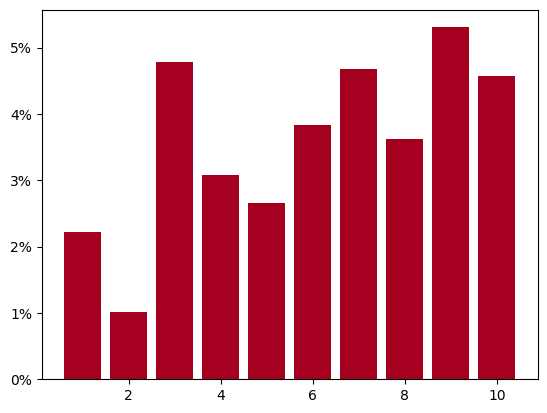

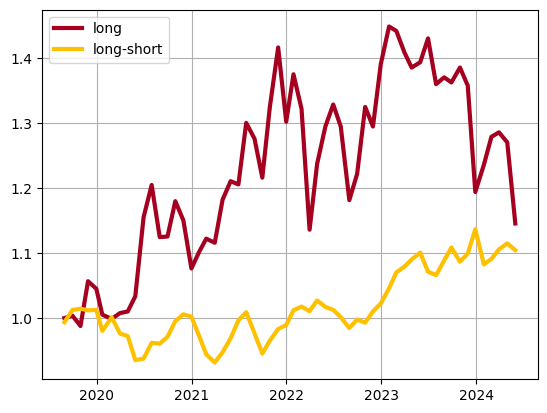

In [95]:
factor = neutral_num
factor_col = 'neutral_factor'

f = pd.merge(
    factor,
    price_adj,
    on=['issue', 'date'],
    how='inner'
)
f_date = f.loc[f['date'] == '2019-08-30', [factor_col, 'ret', 'ret_next']].copy()

def grouped_ret(f, factor_col):
    f_date = f.copy()
    q = f_date[factor_col].quantile(np.arange(0, 1.1, 0.1))
    qcut = pd.cut(f_date[factor_col], q, right=True, labels=np.arange(1, 11))
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

ret = (
    f
        .groupby('date')[[factor_col, 'ret', 'ret_next']]
        .apply(grouped_ret, factor_col=factor_col)
)

ret_annual = (1 + ret.mean()) ** 12 - 1
plt.bar(ret_annual.index, ret_annual, color='#a60021')
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.show()

long = (1 + ret[10]).cumprod()
long_short = (1 + ret[10] - ret[1]).cumprod()
plt.plot(long, linewidth=3, color='#a60021', label='long')
plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
plt.legend()
plt.grid()
plt.show()

## 点度中心性回测

### 读入数据

In [10]:
N_connect_num = feather.read_dataframe('../data/N_connect/N_connect_num.feather')
N_connect_size = feather.read_dataframe('../data/N_connect/N_connect_size.feather')

### 市值行业中性化

In [11]:
neutral_num = neutral_calc(N_connect_num, 'N_connect')
neutral_size = neutral_calc(N_connect_size, 'N_connect')

### IC 测试

In [16]:
df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'IC_IR', 't', "max", 'min'])
IC_num = IC_calc(neutral_num, factor_col='neutral_factor')
df_IC.loc[0]=[
        'N_connect_num',
        IC_num.mean(),
        IC_num.mean() / IC_num.std(),
        np.sqrt(len(IC_num)) * IC_num.mean() / IC_num.std(),
        IC_num.max(),
        IC_num.min()
    ]
IC_size = IC_calc(neutral_size, factor_col='neutral_factor')
df_IC.loc[1]=[
        'N_connect_size',
        IC_size.mean(),
        IC_size.mean() / IC_size.std(),
        np.sqrt(len(IC_size)) * IC_size.mean() / IC_size.std(),
        IC_size.max(),
        IC_size.min()
    ]
df_IC

,factor,IC_mean,IC_IR,t,max,min
0,N_connect_num,0.010421,0.161927,1.23320,0.133239,-0.190505
1,N_connect_size,0.011214,0.154139,1.17389,0.198298,-0.164010


### 分组测试